## DDQN Implementation Exercise
Before beginning this exercise, we highly recommend you read through the [Double DQN Derivation](double_dqn.ipynb) tutorial to get a better grasp of the math behind Double DQN (DDQN).


Since we've already covered most of this in the DQN exercise, we'll copy all the unchanged code over without explanation. You're encouraged to read through the code again to refresh your memory.

In [1]:
import metadrive  # Import this package to register the environment!
import gymnasium as gym
from metadrive.envs.top_down_env import TopDownMetaDrive
gym.register(id="MetaDrive-topdown", entry_point=TopDownMetaDrive, kwargs=dict(config={}))

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


In [2]:
import numpy as np
import numpy.typing as npt

NUM_ACTIONS = 5

def discrete2continuous(action:int) -> npt.NDArray[np.float32]:
    """
    Convert discrete action to continuous action
    """
    assert 0 <= action < NUM_ACTIONS
    throttle_magnitude = 1.0
    brake_magnitude = 1.0
    steering_magnitude = 1.0
    match action:
        case 0:
            return np.array([steering_magnitude, 0.0])
        case 1:
            return np.array([0.0, throttle_magnitude])
        case 2:
            return np.array([0.0, -brake_magnitude])
        case 3:
            return np.array([-steering_magnitude, 0.0])
        case 4:
            return np.array([0.0, 0.0])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Q network
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # input is size 84x84x5
        # output is size NUM_ACTIONS
        self.conv1 = nn.Conv2d(5, 16, kernel_size=8, stride=4) # 84x84x5 -> 20x20x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2) # 20x20x16 -> 9x9x32
        self.fc1 = nn.Linear(9*9*32, 256) # 9x9x32 -> 256
        self.fc2 = nn.Linear(256, NUM_ACTIONS) # 256 -> NUM_ACTIONS

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x)) # Bx84x84x5 -> Bx20x20x16
        x = F.relu(self.conv2(x)) # Bx20x20x16 -> Bx9x9x32
        x = torch.flatten(x, start_dim=1) # Bx9x9x32 -> Bx9*9*32
        x = F.relu(self.fc1(x)) # Bx9*9*32 -> Bx256
        x = self.fc2(x) # Bx256 -> BxNUM_ACTIONS
        return x

In [4]:
def obs_batch_to_tensor(obs: list[npt.NDArray[np.float32]], device: torch.device) -> torch.Tensor:
    """
    Reshape the image observation from (B, H, W, C) to (B, C, H, W) and convert it to a tensor
    """
    return torch.tensor(np.stack(obs), dtype=torch.float32, device=device).permute(0, 3, 1, 2)

In [5]:
def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

class QPolicy:
    def __init__(self, net:QNetwork, epsilon: float = 0.0):
        self.net = net
        self.epsilon = epsilon
    
    def __call__(self, obs: npt.NDArray[np.float32]) -> int:
        """
        Return action given observation
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(NUM_ACTIONS)
        else:
            device = deviceof(self.net)
            obs_batch = obs_batch_to_tensor([obs], device)
            with torch.no_grad():
                q_values = self.net(obs_batch)[0]
                return torch.argmax(q_values).item()

In [6]:
import typing

class Transition(typing.NamedTuple):
    obs: npt.NDArray[np.float32]
    action: int
    reward: float
    next_obs: npt.NDArray[np.float32]
    terminated: bool


def collect_trajectory(env:gym.Env, policy:typing.Callable[[npt.NDArray], int]) -> list[Transition]:
    """
    Collect a trajectory from the environment using the given policy
    """
    trajectory = []

    obs, info = env.reset()

    while True:
        action = policy(obs)
        next_obs, reward, terminated, truncated, info = env.step(discrete2continuous(action))
        trajectory.append(Transition(obs, action, reward, next_obs, terminated))
        if terminated or truncated:
            break
        else:
            obs = next_obs

    return trajectory

In [7]:
import random
class ReplayBuffer():
    def __init__(self, capacity:int = 10000):
        self.capacity = capacity
        self.buffer: list[Transition] = []
        self.position = 0

    def push(self, transition: Transition):
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition
        # Overwrite the earliest stuff if the buffer is full.
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size:int) -> list[Transition]:
        return random.sample(self.buffer, batch_size)

    def __len__(self) -> int:
        return len(self.buffer)

## Double DQN

*Note: We implement the version of DDQN as described by [Hasselt et al. (2015)](https://arxiv.org/abs/1509.06461).*

The key issue with DQNs (as we saw in the previous exercise) is that the max operation in the target Q value calculation is susceptible to overestimation. To address this issue, DDQN proposes to introduce two separate networks: a **primary network** (denoted by $Q_{\phi}$) and a **target network** (denoted by $Q_{\phi_{\text{target}}}$). The primary network is used for action selection, and the target network is used for action evaluation. The target network is updated less frequently than the action network.

The idea is that the primary network will learn to predict the Q-Values for the policy defined by the target network. This also helps eliminate the moving target problem, since the target network is only updated periodically.

#### DDQN Network Update Rule

For:
* Terminal pairs: $Q_{\text{target}}(s, a) = r$
* Non-terminal pairs: $Q_{\text{target}}(s, a) = r + \gamma Q_{\phi_{\text{target}}}(s', \underset{a' \in A}{\operatorname{argmax}} \, Q_{\phi}(s', a'))$

We train the primary network to more closely match the target q-values by minimizing the following loss function:
$$
\mathcal{L}(\phi) = \mathbb{E}_{s, a, r, s'} \left[ \left( Q_{\phi}(s, a) - Q_{\text{target}}(s, a) \right)^2 \right]
$$

In [8]:
def compute_target_q_values(
        primary_q_network: QNetwork,
        target_q_network: QNetwork,
        rewards: list[float],
        next_observations: list[npt.NDArray[np.float32]],
        terminateds: list[bool],
        gamma: float
) -> list[float]:
    """
    Compute the target Q values for the transitions
    """
    # assert that the lengths of the lists are the same
    n_transitions = len(rewards)
    assert len(next_observations) == n_transitions
    assert len(terminateds) == n_transitions

    # assert that primary and target networks are on the same device
    device = deviceof(primary_q_network)
    assert deviceof(target_q_network) == device

    # compute the Q_target(s', a') values
    next_obs_batch = obs_batch_to_tensor(next_observations, device)
    with torch.no_grad():
        primary_next_q_values = primary_q_network(next_obs_batch)
        target_next_q_values = target_q_network(next_obs_batch)

    # compute argmax_a' Q_phi(s', a') for each transition
    argmax_next_q_values = torch.max(primary_next_q_values, dim=1).indices

    # compute the Q_phi_target(s', argmax_a' Q_phi(s', a')) values
    max_next_q_values = target_next_q_values[range(n_transitions), argmax_next_q_values]
    
    # compute the target Q values
    target_q_values = []
    for reward, terminated, max_next_q_value in zip(rewards, terminateds, max_next_q_values):
        if terminated:
            target_q_values.append(reward)
        else:
            target_q_values.append(reward + gamma * float(max_next_q_value))

    return target_q_values

We train the Q-Network to try to predict these target Q values. We use MSE loss to train the network, but another popular choice is Huber loss.

In [9]:
def train_primary_q_network(
        primary_q_network: QNetwork,
        target_q_network: QNetwork,
        optimizer: torch.optim.Optimizer,
        transitions: list[Transition],
        gamma: float
) -> float:
    """
    Train the Q network using the given transitions
    """
    # unpack the transitions
    obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch = zip(*transitions)
    
    device = deviceof(primary_q_network)

    # compute the target Q values
    target_q_values = compute_target_q_values(primary_q_network, target_q_network, reward_batch, next_obs_batch, terminated_batch, gamma)
    target_q_values_tensor = torch.tensor(target_q_values, dtype=torch.float32, device=device)

    # compute the Q values for the picked actions
    obs_batch = obs_batch_to_tensor(obs_batch, device)
    all_q_values = primary_q_network(obs_batch)
    q_values = all_q_values[range(len(action_batch)), action_batch]

    # compute the loss
    loss = F.mse_loss(q_values, target_q_values_tensor)

    # perform gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return float(loss)

def soft_update_target_q_network(primary_q_network: QNetwork, target_q_network: QNetwork, tau: float):
    """
    Soft update the target Q network
    """
    # assert that primary and target networks are on the same device
    device = deviceof(primary_q_network)
    assert deviceof(target_q_network) == device

    # update the target network parameters
    for primary_param, target_param in zip(primary_q_network.parameters(), target_q_network.parameters()):
        target_param.data.copy_(tau * primary_param.data + (1 - tau) * target_param.data)

### Training Loop

Now, we can finally begin training the network.

In [10]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.top_down_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [11]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

primary_q_network = QNetwork().to(device)
target_q_network = QNetwork().to(device)

q_optimizer = torch.optim.Adam(primary_q_network.parameters())

policy = QPolicy(primary_q_network, epsilon=0.3)

replay_buffer = ReplayBuffer()

step = 0
returns = []
losses = []

In [12]:
env = gym.make("MetaDrive-topdown", config={"use_render": False, "horizon": 300, "num_scenarios": 100})

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -0.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [13]:
TRAIN_EPOCHS = 100
EPISODES_PER_BATCH = 32
GAMMA = 0.80
TAU = 1e-3
set_lr(q_optimizer, 1e-4)

# Train
while step < TRAIN_EPOCHS:
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        # Collect trajectory
        transitions = collect_trajectory(env, policy)
        rew_traj = [t.reward for t in transitions]

        # Update replay buffer
        for t in transitions:
            replay_buffer.push(t)

        # Update trajectory returns
        trajectory_returns.append(sum(rew_traj))

    loss = train_primary_q_network(
        primary_q_network,
        target_q_network,
        q_optimizer,
        replay_buffer.sample(EPISODES_PER_BATCH),
        GAMMA
    )
    soft_update_target_q_network(primary_q_network, target_q_network, TAU)

    # slowly decay the epsilon
    policy.epsilon = policy.epsilon * 0.97

    # collect statistics
    returns.append(trajectory_returns)
    losses.append(loss)

    print(f"Step {step}, Avg. Returns: {np.mean(trajectory_returns):.3f} +/- {np.std(trajectory_returns):.3f}, Median: {np.median(trajectory_returns):.3f}, Q-Network Loss: {losses[-1]:.3f}")

    step += 1

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
:device(warning): /dev/input/event4 is not readable, some features will be unavailable.
:device(warning): /dev/input/event5 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.


Step 0, Avg. Returns: 0.541 +/- 0.154, Median: 0.510, Q-Network Loss: 0.005
Step 1, Avg. Returns: 0.530 +/- 0.169, Median: 0.513, Q-Network Loss: 0.002
Step 2, Avg. Returns: 0.523 +/- 0.197, Median: 0.516, Q-Network Loss: 0.001
Step 3, Avg. Returns: 0.523 +/- 0.184, Median: 0.547, Q-Network Loss: 0.000
Step 4, Avg. Returns: 0.375 +/- 0.619, Median: 0.480, Q-Network Loss: 0.000
Step 5, Avg. Returns: 10.000 +/- 3.023, Median: 9.360, Q-Network Loss: 0.003
Step 6, Avg. Returns: 10.465 +/- 4.037, Median: 10.359, Q-Network Loss: 0.003
Step 7, Avg. Returns: 11.001 +/- 3.789, Median: 10.192, Q-Network Loss: 0.001
Step 8, Avg. Returns: 10.444 +/- 4.408, Median: 9.657, Q-Network Loss: 0.002
Step 9, Avg. Returns: 12.004 +/- 8.452, Median: 10.193, Q-Network Loss: 0.003
Step 10, Avg. Returns: 12.468 +/- 3.753, Median: 11.798, Q-Network Loss: 0.002


KeyboardInterrupt: 

In [ ]:
env.close()

Let's visualize the policy we learned:

In [ ]:
env = gym.make("MetaDrive-topdown", config={"use_render": True, "horizon": 500, "num_scenarios": 100})
transitions = collect_trajectory(env, QPolicy(primary_q_network, epsilon=0.0))
env.close()

rew = [t.reward for t in transitions]

print("Reward:", sum(rew))

Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Reward: 64.83419519862899


For us, the learned policy consisted pretty much of just going straight at full speed. This is because the agent is rewarded for moving forward. DQN never learned to steer.

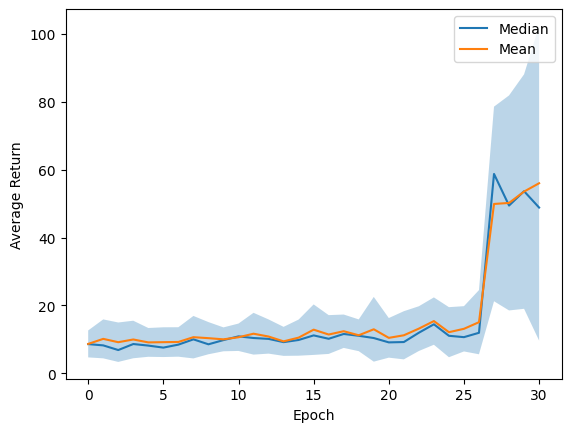

In [ ]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_medians, label="Median")
plt.plot(return_means, label="Mean")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()

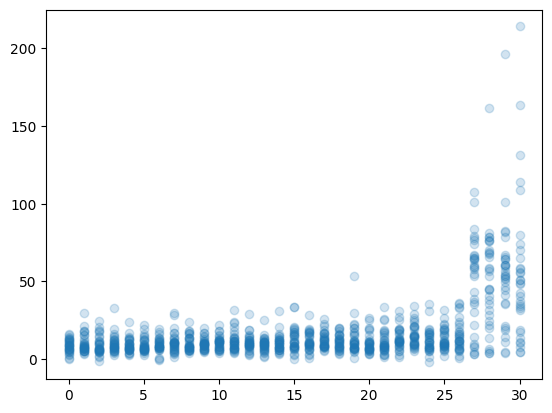

In [ ]:
# scatter plot of the returns
xs = []
ys = []
for t, rets in enumerate(returns):
    for ret in rets:
        xs.append(t)
        ys.append(ret)
plt.scatter(xs, ys, alpha=0.2)